## Analysis of Integrated multi-omics single cell atlas of the human retina
- QC
- EDA
- Clustering
- Clustering Analysis

In [34]:
import sys
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import dill
import matplotlib.pyplot as plt

In [32]:
sys.version

'3.10.5 (main, Jul 19 2022, 08:28:45) [GCC 6.2.0]'

In [7]:
adata = sc.read_h5ad("d0183df5-815d-48c2-bcfe-fbf9b716505c.h5ad")

In [8]:
print(adata)

AnnData object with n_obs × n_vars = 330930 × 32034
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'pANN', 'sampleid', 'subclass_label', 'majorclass', 'author_cell_type', 'age', 'gender', 'reference', 'accession', 'sample_note', 'development_stage_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'organism_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'tissue_type', 'library_platform', 'cell_type_ontology_term_id', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'gene_symbols', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'citation', 'default_embedding', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_scVI', 'X_umap'


In [9]:
display(adata.obs.head())
display(adata.var.head())

,nCount_RNA,nFeature_RNA,percent.mt,pANN,sampleid,subclass_label,majorclass,author_cell_type,age,gender,...,is_primary_data,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid
10x3_Ms_WT_P14_AAACCCAAGGGATCTG-1,8090.0,3062.0,9.431397,0.191304,10x3_Ms_WT_P14,NaN,BC,RBC,P14,Male,...,True,rod bipolar cell,10x 3' v3,normal,Mus musculus,male,retina,na,2 weeks,O;1d2cRM*r
10x3_Ms_WT_P14_AAACCCACATGGATCT-1,8397.0,3145.0,7.264499,0.217391,10x3_Ms_WT_P14,NaN,BC,RBC,P14,Male,...,True,rod bipolar cell,10x 3' v3,normal,Mus musculus,male,retina,na,2 weeks,<&_ecXlzow
10x3_Ms_WT_P14_AAAGTCCAGCTGAAGC-1,11927.0,3686.0,8.325648,0.200000,10x3_Ms_WT_P14,NaN,BC,RBC,P14,Male,...,True,rod bipolar cell,10x 3' v3,normal,Mus musculus,male,retina,na,2 weeks,o(0Cc`LhFQ
10x3_Ms_WT_P14_AAATGGAGTCACCCTT-1,10331.0,3621.0,6.427258,0.173913,10x3_Ms_WT_P14,NaN,BC,RBC,P14,Male,...,True,rod bipolar cell,10x 3' v3,normal,Mus musculus,male,retina,na,2 weeks,)?i*V-3{5!
10x3_Ms_WT_P14_AACACACCAGAACTAA-1,11236.0,3739.0,6.034176,0.165217,10x3_Ms_WT_P14,NaN,BC,RBC,P14,Male,...,True,rod bipolar cell,10x 3' v3,normal,Mus musculus,male,retina,na,2 weeks,<?%Qa*+>_>


,gene_symbols,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length
ENSMUSG00000109644,0610005C13Rik,False,0610005C13Rik,NCBITaxon:10090,gene,3588
ENSMUSG00000108652,0610006L08Rik,False,0610006L08Rik,NCBITaxon:10090,gene,2128
ENSMUSG00000007777,0610009B22Rik,False,0610009B22Rik,NCBITaxon:10090,gene,998
ENSMUSG00000086714,0610009E02Rik,False,0610009E02Rik,NCBITaxon:10090,gene,2977
ENSMUSG00000043644,0610009L18Rik,False,0610009L18Rik,NCBITaxon:10090,gene,1394


## QC

In [10]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var['feature_name'].str.startswith("mt-")

In [11]:
adata.var[adata.var["mt"]]

,gene_symbols,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,mt
ENSMUSG00000064357,mt-Atp6,False,mt-Atp6,NCBITaxon:10090,gene,681,True
ENSMUSG00000064356,mt-Atp8,False,mt-Atp8,NCBITaxon:10090,gene,204,True
ENSMUSG00000064351,mt-Co1,False,mt-Co1,NCBITaxon:10090,gene,1545,True
ENSMUSG00000064354,mt-Co2,False,mt-Co2,NCBITaxon:10090,gene,684,True
ENSMUSG00000064358,mt-Co3,False,mt-Co3,NCBITaxon:10090,gene,784,True
ENSMUSG00000064370,mt-Cytb,False,mt-Cytb,NCBITaxon:10090,gene,1144,True
ENSMUSG00000064341,mt-Nd1,False,mt-Nd1,NCBITaxon:10090,gene,957,True
ENSMUSG00000064345,mt-Nd2,False,mt-Nd2,NCBITaxon:10090,gene,1038,True
ENSMUSG00000064360,mt-Nd3,False,mt-Nd3,NCBITaxon:10090,gene,348,True
ENSMUSG00000064363,mt-Nd4,False,mt-Nd4,NCBITaxon:10090,gene,1378,True


In [12]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, log1p=True
)

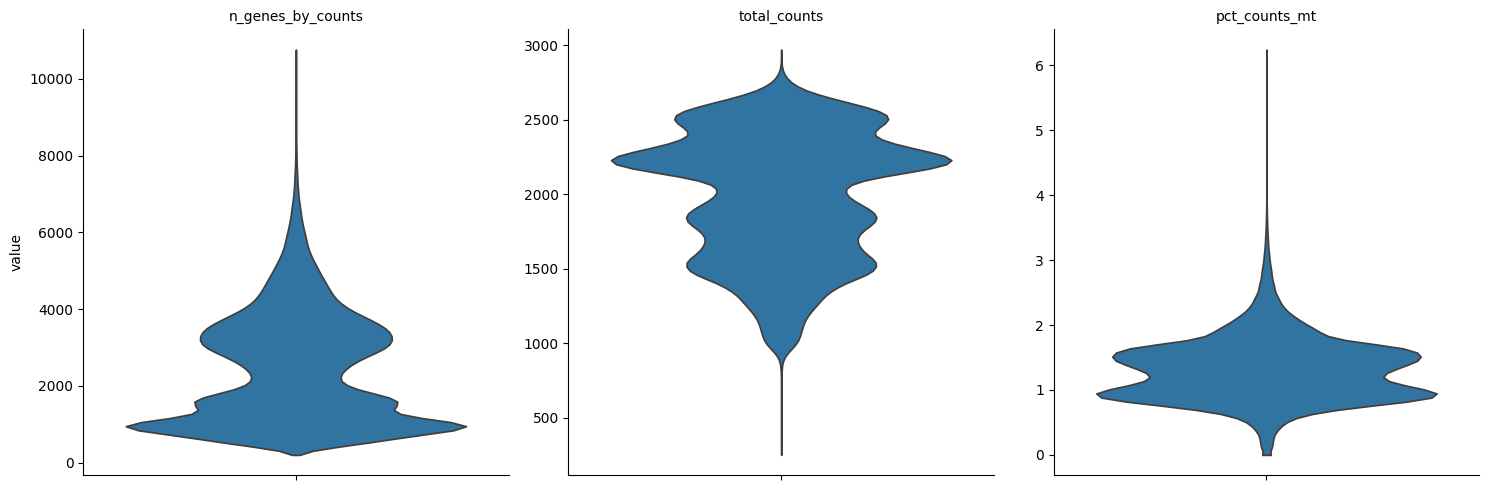

In [13]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    stripplot = False,
    multi_panel=True,
)

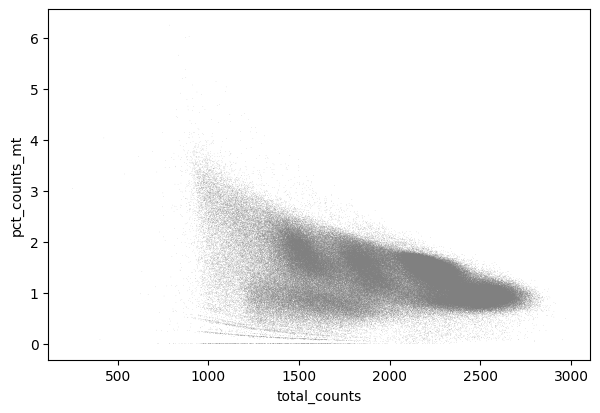

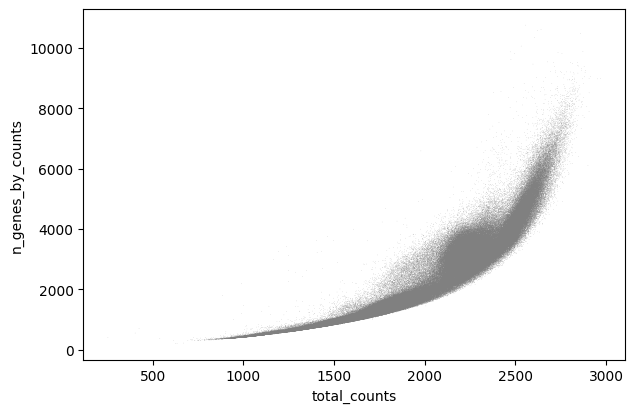

In [14]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

### Mitochondrial Sanity Check

In [15]:
# Get the mitochondrial genes
mitochondrial_genes = adata.var[adata.var['mt']]

# Get the names of mitochondrial genes
mitochondrial_genes_names = mitochondrial_genes['feature_name']

def print_gene_expression(cell_of_interest):
    # Get the gene expression values for mitochondrial genes for the specified cell
    gene_expression = adata[cell_of_interest, adata.var['mt']].X
    
    # Convert the sparse matrix to a dense array if necessary
    if hasattr(gene_expression, "toarray"):
        gene_expression = gene_expression.toarray()
    
    # Get the percent.mt value for the cell
    percent_mt = adata.obs.loc[cell_of_interest, 'percent.mt']
    
    # Display the gene expression values
    print(f"\nGene expression values for mitochondrial genes in {cell_of_interest} (percent.mt: {percent_mt:.2f}%):")
    for gene, expr in zip(mitochondrial_genes_names, gene_expression.flatten()):  # .flatten() to ensure it's a 1D array
        print(f"{gene}: {expr}")

# Specify the first cell by its index position
cell_mt_max = adata.obs['percent.mt'].idxmax()

# Find the cell with the highest percent.mt
cell_mt_min = adata.obs['percent.mt'].idxmin()

# Get the mitochondrial genes
mitochondrial_genes = adata.var[adata.var['mt']]

# Get the names of mitochondrial genes
mitochondrial_genes_names = mitochondrial_genes['feature_name']

# Print gene expression for the first cell
print_gene_expression(cell_mt_max)

# Print gene expression for the cell with the highest percent.mt
print_gene_expression(cell_mt_min)



Gene expression values for mitochondrial genes in 10x3_Ms_WT_P14_GTGTGGCGTCAACGCC-1 (percent.mt: 10.00%):
mt-Atp6: 4.5594353675842285
mt-Atp8: 1.276137351989746
mt-Co1: 4.33620548248291
mt-Co2: 4.414199352264404
mt-Co3: 4.6017842292785645
mt-Cytb: 4.039323806762695
mt-Nd1: 2.7384846210479736
mt-Nd2: 2.3319485187530518
mt-Nd3: 1.8189771175384521
mt-Nd4: 2.833989381790161
mt-Nd4l: 1.6355808973312378
mt-Nd5: 1.529503345489502
mt-Nd6: 0.4164412021636963

Gene expression values for mitochondrial genes in 10x3_Ms_WT_P14_AAGAACAGTATTAAGG-1 (percent.mt: 0.00%):
mt-Atp6: 0.0
mt-Atp8: 0.0
mt-Co1: 0.0
mt-Co2: 0.0
mt-Co3: 0.0
mt-Cytb: 0.0
mt-Nd1: 0.0
mt-Nd2: 0.0
mt-Nd3: 0.0
mt-Nd4: 0.0
mt-Nd4l: 0.0
mt-Nd5: 0.0
mt-Nd6: 0.0


### Filtering Cells

In [16]:
# Initial number of cells
initial_cells = adata.shape[0]

# Define filter thresholds
min_genes = 200
max_genes = 6000
min_counts = 1000
max_counts = 50000
max_percent_mt = 10

# Filter cells
sc.pp.filter_cells(adata, min_genes=min_genes)
adata = adata[adata.obs['nFeature_RNA'] < max_genes, :]
adata = adata[adata.obs['nCount_RNA'] > min_counts, :]
adata = adata[adata.obs['nCount_RNA'] < max_counts, :]
adata = adata[adata.obs['percent.mt'] < max_percent_mt, :]

# Final number of cells
final_cells = adata.shape[0]
total_removed = initial_cells - final_cells

print(f"Initial number of cells: {initial_cells}")
print(f"Final number of cells: {final_cells}")
print(f"Total cells removed: {total_removed}")

Initial number of cells: 330930
Final number of cells: 172969
Total cells removed: 157961


In [17]:
# Initial number of genes
initial_genes = adata.shape[1]

# Apply filters
sc.pp.filter_genes(adata, min_cells=3)

# Final number of genes
final_genes = adata.shape[1]
total_removed = initial_genes - final_genes

print(f"Initial number of genes: {initial_genes}")
print(f"Final number of genes: {final_genes}")
print(f"Total genes removed: {total_removed}")

/project/hipaa_ycheng11lab/atlas/CAMR2024/py310env/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:275: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Initial number of genes: 32034
Final number of genes: 25973
Total genes removed: 6061


In [18]:
# Doublet test
adata_sub = sc.pp.subsample(adata, fraction = .01, copy = True)
print(adata_sub.shape)

sc.pp.scrublet(adata_sub)
print(adata_sub.obs["predicted_doublet"].sum())

(1729, 25973)
4


Looks like there's probably around 600 doublets

### Normalization

In [19]:
# Saving count data
adata.layers["raw"] = adata.X.copy()

In [20]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

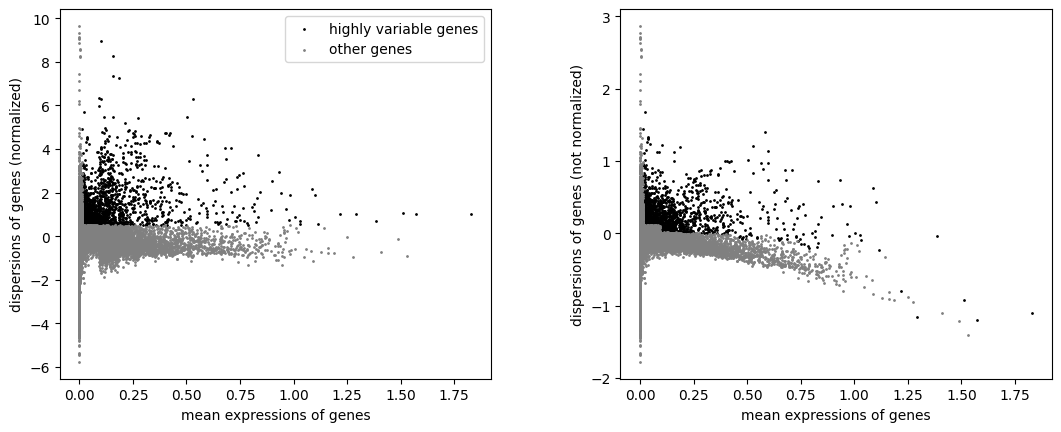

In [21]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

How is dispersion measured when there's no section sample?

### PCA

In [22]:
sc.tl.pca(adata)

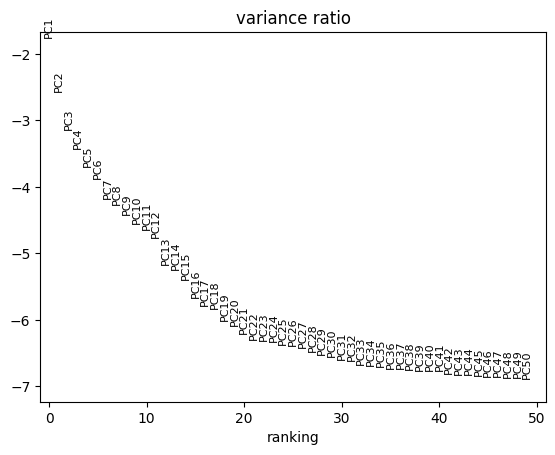

In [23]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

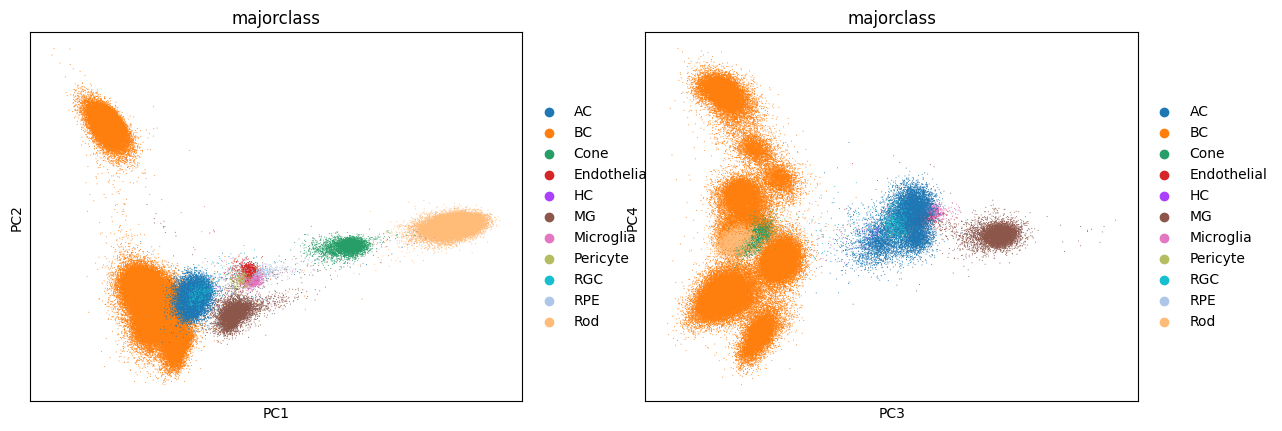

In [24]:
sc.pl.pca(
    adata,
    color=["majorclass"],
    dimensions=[(0, 1), (2, 3)],
    ncols=2,
    size=2,
)

## Clustering

In [25]:
sc.pp.neighbors(adata)

/project/hipaa_ycheng11lab/atlas/CAMR2024/py310env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
for res in [0.02, 0.5, 2.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph"
    )

In [27]:
print(adata)

AnnData object with n_obs × n_vars = 172969 × 25973
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'pANN', 'sampleid', 'subclass_label', 'majorclass', 'author_cell_type', 'age', 'gender', 'reference', 'accession', 'sample_note', 'development_stage_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'organism_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'tissue_type', 'library_platform', 'cell_type_ontology_term_id', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden_res_0.02', 'l

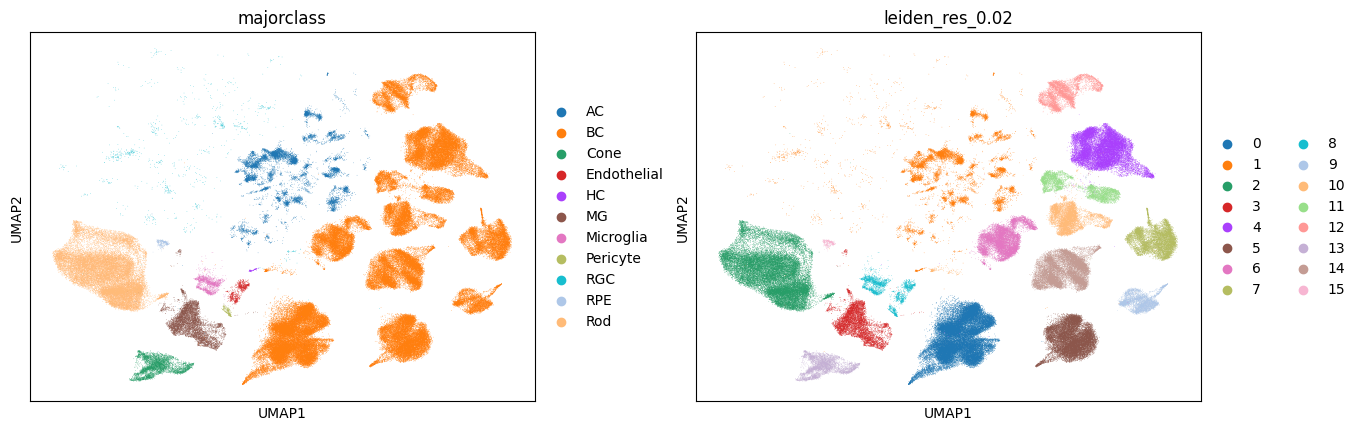

In [28]:
sc.pl.umap(
    adata,
    color=["majorclass", "leiden_res_0.02"],
    wspace=.2
)

## Gene Expression Analysis

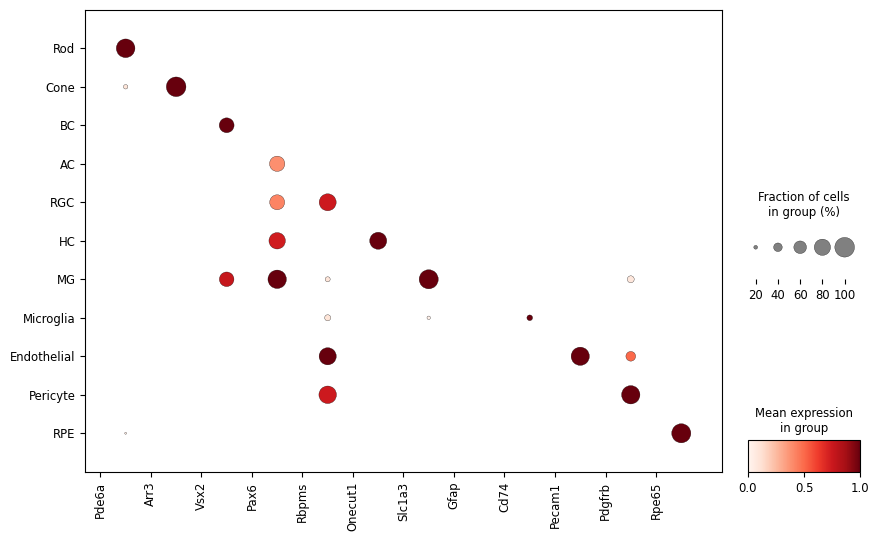

In [35]:
# List of gene symbols in the desired order
gene_symbols = ['Pde6a', 'Arr3', 'Vsx2', 'Pax6', 'Rbpms', 'Onecut1', 'Slc1a3', 'Gfap', 'Cd74', 'Pecam1', 'Pdgfrb', 'Rpe65']

# Ensure that 'majorclass' in adata.obs is a categorical variable
# and order the categories as desired
cell_type_order = ['Rod', 'Cone', 'BC', 'AC', 'RGC', 'HC', 'MG', 'Astrocyte', 'Microglia', 'Endothelial', 'Pericyte', 'RPE']
adata.obs['majorclass'] = pd.Categorical(adata.obs['majorclass'], categories=cell_type_order, ordered=True)

# Create a dictionary mapping gene symbols to var_names
gene_symbol_to_var_name = {gene_symbol: var_name for gene_symbol, var_name in zip(adata.var['gene_symbols'], adata.var.index) if gene_symbol in gene_symbols}

# Ensure the gene symbols are in the desired order and map them to var_names
ordered_var_names = [gene_symbol_to_var_name[gene] for gene in gene_symbols]

# Plot the dot plot
dotplot = sc.pl.dotplot(
    adata,
    var_names=ordered_var_names,  # List of var_names corresponding to the gene symbols in the desired order
    groupby='majorclass',  # Column in adata.obs to group by (e.g., cell types)
    var_group_labels=gene_symbols,  # Use gene symbols as labels
    standard_scale='var',  # Scale expression per gene (var) or cell type (obs)
    dot_min=0.1,  # Minimum dot size
    dot_max=1,  # Maximum dot size
    color_map='Reds',  # Color map for expression
    figsize=(10, 6),  # Size of the figure
    show=False  # Do not show plot immediately
)

# Customize the x-axis tick labels
ax = dotplot['mainplot_ax']
ax.set_xticks(range(len(gene_symbols)))
ax.set_xticklabels(gene_symbols, rotation=90)

# Show the plot
plt.show()

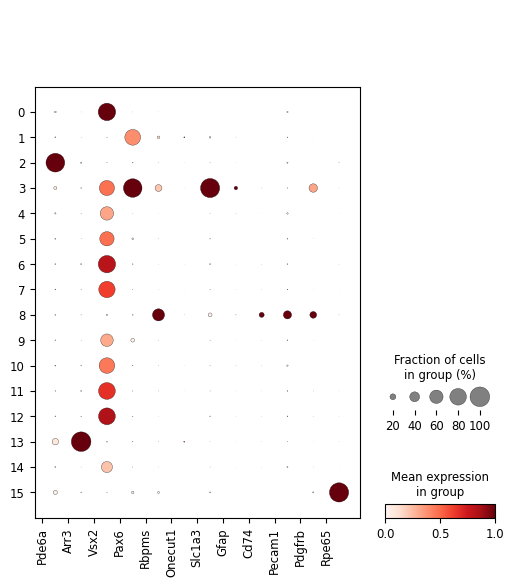

In [39]:
dotplot = sc.pl.dotplot(adata, ordered_var_names, groupby="leiden_res_0.02", standard_scale="var", show=False)

# Customize the x-axis tick labels
ax = dotplot['mainplot_ax']
ax.set_xticks(range(len(gene_symbols)))
ax.set_xticklabels(gene_symbols, rotation=90)

plt.show()

In [ ]:
# Save the entire session
filename = 'notebook_state.pkl'
with open(filename, 'wb') as f:
    dill.dump_session(f)

In [ ]:
import dill

# Load the entire session
filename = 'notebook_state.pkl'
with open(filename, 'rb') as f:
    dill.load_session(f)

NameError: name 'UnpicklingError' is not defined